<a href="https://colab.research.google.com/github/jeonghoya/Machine-Learning-Programming/blob/main/week3/WISDM_ar_v1_1_raw_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 모델 라이브러리
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import warnings

In [2]:
# 1. 원본 txt 파일 로드 (세미콜론 제거 필요)
# 파일 마지막에 붙은 세미콜론 때문에 에러가 날 수 있어, 먼저 파일을 읽고 처리합니다.
filepath = '/content/drive/MyDrive/Colab Notebooks/WISDM_ar_v1.1_raw.txt'
data = []
with open(filepath, 'r') as f:
    for line in f:
        # 각 줄의 끝에 있는 세미콜론과 공백을 제거하고 쉼표로 분리
        cleaned_line = line.strip().rstrip(';').split(',')
        if len(cleaned_line) == 6: # 데이터가 6개 열로 완전한 경우에만 추가
            data.append(cleaned_line)

# 2. Pandas DataFrame으로 변환 및 컬럼명 지정
columns = ['user', 'activity', 'timestamp', 'x-accel', 'y-accel', 'z-accel']
df = pd.DataFrame(data, columns=columns)

# 3. 데이터 타입 변환 (숫자형으로)
df['x-accel'] = pd.to_numeric(df['x-accel'])
df['y-accel'] = pd.to_numeric(df['y-accel'])
df['z-accel'] = pd.to_numeric(df['z-accel'])

# 4. 정제된 CSV 파일로 저장
df.to_csv('WISDM_ar_v1.1_cleaned.csv', index=False)

print("CSV 파일 변환 및 저장 완료!")
display(df.head())

CSV 파일 변환 및 저장 완료!


,user,activity,timestamp,x-accel,y-accel,z-accel
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086466 entries, 0 to 1086465
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1086466 non-null  object 
 1   activity   1086466 non-null  object 
 2   timestamp  1086466 non-null  object 
 3   x-accel    1086466 non-null  float64
 4   y-accel    1086466 non-null  float64
 5   z-accel    1086465 non-null  float64
dtypes: float64(3), object(3)
memory usage: 49.7+ MB


In [4]:
df.isnull().sum()

,0
user,0
activity,0
timestamp,0
x-accel,0
y-accel,0
z-accel,1


In [5]:
# z-accel에 결측치가 하나라도 있는 경우 해당 행을 제거
if df['z-accel'].isnull().any():
    df.dropna(inplace=True)
    print("\n✅ 결측치가 포함된 행을 제거했습니다.")
else:
    print("\n✅ 확인 결과, 결측치가 없습니다.")

print("\n[처리 후 결측치 개수]")
print(df.isnull().sum())


✅ 결측치가 포함된 행을 제거했습니다.

[처리 후 결측치 개수]
user         0
activity     0
timestamp    0
x-accel      0
y-accel      0
z-accel      0
dtype: int64


In [6]:
# 불필요한 컬럼 제거 및 결측치 처리
df.drop(columns=['user', 'timestamp'], inplace=True, errors='ignore')

In [7]:
# 레이블 인코딩
le = LabelEncoder()
df['activity_encoded'] = le.fit_transform(df['activity'])
NUM_CLASSES = len(le.classes_)
print(f"\n활동 레이블: {le.classes_}")
print(f"클래스 개수: {NUM_CLASSES}")

# 피처 스케일링
scaler = StandardScaler()
feature_cols = ['x-accel', 'y-accel', 'z-accel']
df[feature_cols] = scaler.fit_transform(df[feature_cols])
print("✅ 데이터 전처리 완료")


활동 레이블: ['Downstairs' 'Jogging' 'Sitting' 'Standing' 'Upstairs' 'Walking']
클래스 개수: 6
✅ 데이터 전처리 완료


In [8]:
print("\n--- 레이블과 숫자 매핑 결과 ---")
# le.classes_ 배열의 인덱스가 곧 인코딩된 숫자입니다.
for idx, label in enumerate(le.classes_):
    print(f"'{label}' -> {idx}")


--- 레이블과 숫자 매핑 결과 ---
'Downstairs' -> 0
'Jogging' -> 1
'Sitting' -> 2
'Standing' -> 3
'Upstairs' -> 4
'Walking' -> 5


In [9]:
# --- 3. 범주형 데이터 분석 (activity 컬럼) ---
print("\n\n--- 3. 활동(Activity) 데이터 분포 확인 ---")
activity_counts = df['activity'].value_counts()
print("[각 활동별 데이터 개수]")
print(activity_counts)



--- 3. 활동(Activity) 데이터 분포 확인 ---
[각 활동별 데이터 개수]
activity
Walking       418393
Jogging       336445
Upstairs      122869
Downstairs    100425
Sitting        59939
Standing       48394
Name: count, dtype: int64


/tmp/ipython-input-3992636053.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='activity', data=df, order=activity_counts.index, palette='viridis')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44060 (\N

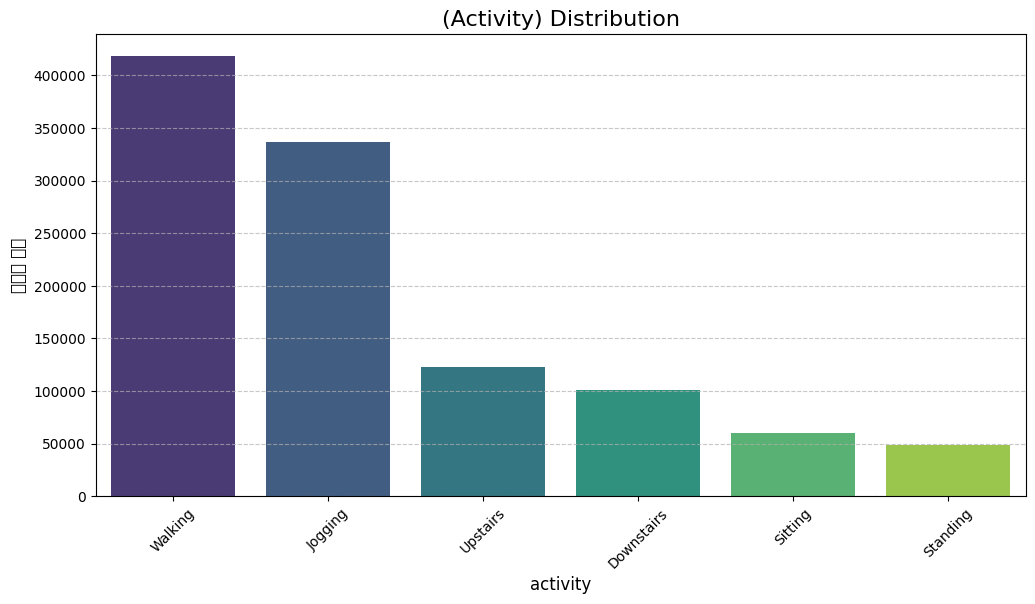

In [10]:
# 활동별 데이터 개수 시각화
plt.figure(figsize=(12, 6))
sns.countplot(x='activity', data=df, order=activity_counts.index, palette='viridis')
plt.title('(Activity) Distribution', fontsize=16)
plt.xlabel('activity', fontsize=12)
plt.ylabel('데이터 개수', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [11]:
df.drop(columns=['activity'], inplace=True, errors='ignore')
display(df.head())

,x-accel,y-accel,z-accel,activity_encoded
0,-0.197600,0.806331,0.022317,1
1,0.632345,0.596159,0.116722,1
2,0.616498,0.539574,-0.100695,1
3,-0.185715,1.669250,0.551556,1
4,-0.268908,0.721454,1.429807,1


In [12]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import warnings

In [13]:
# --- 2. 슬라이딩 윈도우 생성 (CNN과 동일) ---
print("\n--- 2. 슬라이딩 윈도우 생성 시작 ---")
def create_segments(df, time_steps, step, label_col, feature_cols):
    feature_values = df[feature_cols].values
    label_values = df[label_col].values
    num_segments = len(range(0, len(df) - time_steps, step))
    segments = np.empty((num_segments, time_steps, len(feature_cols)))
    labels = np.empty(num_segments, dtype=int)
    idx = 0
    for i in range(0, len(df) - time_steps, step):
        segments[idx] = feature_values[i: i + time_steps]
        label_result = stats.mode(label_values[i: i + time_steps]).mode
        labels[idx] = np.array(label_result).flatten()[0]
        idx += 1
    return segments, labels

Fs = 20
TIME_STEPS = Fs * 4  # 80
STEP_SIZE = Fs * 2   # 40


--- 2. 슬라이딩 윈도우 생성 시작 ---


In [14]:
X, y = create_segments(df, TIME_STEPS, STEP_SIZE, 'activity_encoded', feature_cols)
print(f"✅ 생성된 세그먼트 형태: X={X.shape}, y={y.shape}")

✅ 생성된 세그먼트 형태: X=(27160, 80, 3), y=(27160,)


In [15]:
# --- 3. 데이터 분할 및 Tensor 변환 (CNN과 동일) ---
print("\n--- 3. 데이터 분할 및 Tensor 변환 시작 ---")
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
print("✅ PyTorch Tensor 변환 완료")


--- 3. 데이터 분할 및 Tensor 변환 시작 ---
✅ PyTorch Tensor 변환 완료


In [16]:
# --- 4. PyTorch Dataset 및 DataLoader 생성 (CNN과 동일) ---
BATCH_SIZE = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("✅ DataLoader 준비 완료 (train, validation, test)")

✅ DataLoader 준비 완료 (train, validation, test)


In [17]:
# --- 5. LSTM 모델 정의 (이 부분만 변경) ---
class HAR_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(HAR_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # batch_first=True -> (배치, 시퀀스, 피처) 형태의 입력을 받음
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # LSTM의 마지막 타임스텝의 출력을 분류기로 전달
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # 초기 hidden state와 cell state를 0으로 설정
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM 순전파
        out, _ = self.lstm(x, (h0, c0))

        # 마지막 타임스텝의 출력만 사용
        out = self.fc(out[:, -1, :])
        return out

# LSTM 하이퍼파라미터
INPUT_SIZE = len(feature_cols) # 3
HIDDEN_SIZE = 64
NUM_LAYERS = 2

In [18]:
model = HAR_LSTM(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES)
print("\n--- 5. 모델 구조 ---")
print(model)


--- 5. 모델 구조 ---
HAR_LSTM(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)


In [19]:
# --- 6. 모델 훈련 및 평가 (CNN과 동일) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"\n--- 6. 모델 훈련 시작 (Device: {device}) ---")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
NUM_EPOCHS = 20

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    for segments, labels in train_loader:
        segments, labels = segments.to(device), labels.to(device)
        outputs = model(segments)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    model.eval()
    running_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for segments, labels in val_loader:
            segments, labels = segments.to(device), labels.to(device)
            outputs = model(segments)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_loss = running_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

print("✅ 모델 훈련 완료")


--- 6. 모델 훈련 시작 (Device: cuda) ---
Epoch [1/20], Train Loss: 1.0802, Train Acc: 63.08%, Val Loss: 0.8353, Val Acc: 72.73%
Epoch [2/20], Train Loss: 0.7819, Train Acc: 73.70%, Val Loss: 0.7752, Val Acc: 73.26%
Epoch [3/20], Train Loss: 0.7825, Train Acc: 73.32%, Val Loss: 0.7496, Val Acc: 74.07%
Epoch [4/20], Train Loss: 0.7542, Train Acc: 74.04%, Val Loss: 0.7567, Val Acc: 73.91%
Epoch [5/20], Train Loss: 0.6697, Train Acc: 76.53%, Val Loss: 0.6010, Val Acc: 79.08%
Epoch [6/20], Train Loss: 0.6306, Train Acc: 78.08%, Val Loss: 0.5419, Val Acc: 80.37%
Epoch [7/20], Train Loss: 0.5350, Train Acc: 81.18%, Val Loss: 0.5053, Val Acc: 82.74%
Epoch [8/20], Train Loss: 0.4977, Train Acc: 82.41%, Val Loss: 0.4679, Val Acc: 82.86%
Epoch [9/20], Train Loss: 0.4459, Train Acc: 84.06%, Val Loss: 0.4124, Val Acc: 86.08%
Epoch [10/20], Train Loss: 0.3987, Train Acc: 85.88%, Val Loss: 0.3851, Val Acc: 86.75%
Epoch [11/20], Train Loss: 0.3263, Train Acc: 88.84%, Val Loss: 0.2767, Val Acc: 90.75%
Epoch

In [20]:
# --- 7. 최종 테스트 데이터 평가 (CNN과 동일) ---
print("\n--- 7. 최종 모델 평가 시작 ---")
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    correct, total = 0, 0
    for segments, labels in test_loader:
        segments, labels = segments.to(device), labels.to(device)
        outputs = model(segments)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
accuracy = 100 * correct / total
print(f'✅ 최종 테스트 데이터 정확도: {accuracy:.2f} %')


--- 7. 최종 모델 평가 시작 ---
✅ 최종 테스트 데이터 정확도: 96.32 %


In [21]:
# --- 8. Classification Report (CNN과 동일) ---
print("\n--- 8. Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=le.classes_))


--- 8. Classification Report ---
              precision    recall  f1-score   support

  Downstairs       0.91      0.87      0.89       503
     Jogging       0.99      0.98      0.98      1682
     Sitting       0.99      0.94      0.96       299
    Standing       0.93      1.00      0.96       242
    Upstairs       0.89      0.90      0.90       614
     Walking       0.98      0.99      0.98      2092

    accuracy                           0.96      5432
   macro avg       0.95      0.95      0.95      5432
weighted avg       0.96      0.96      0.96      5432




--- 9. 훈련 과정 시각화 ---


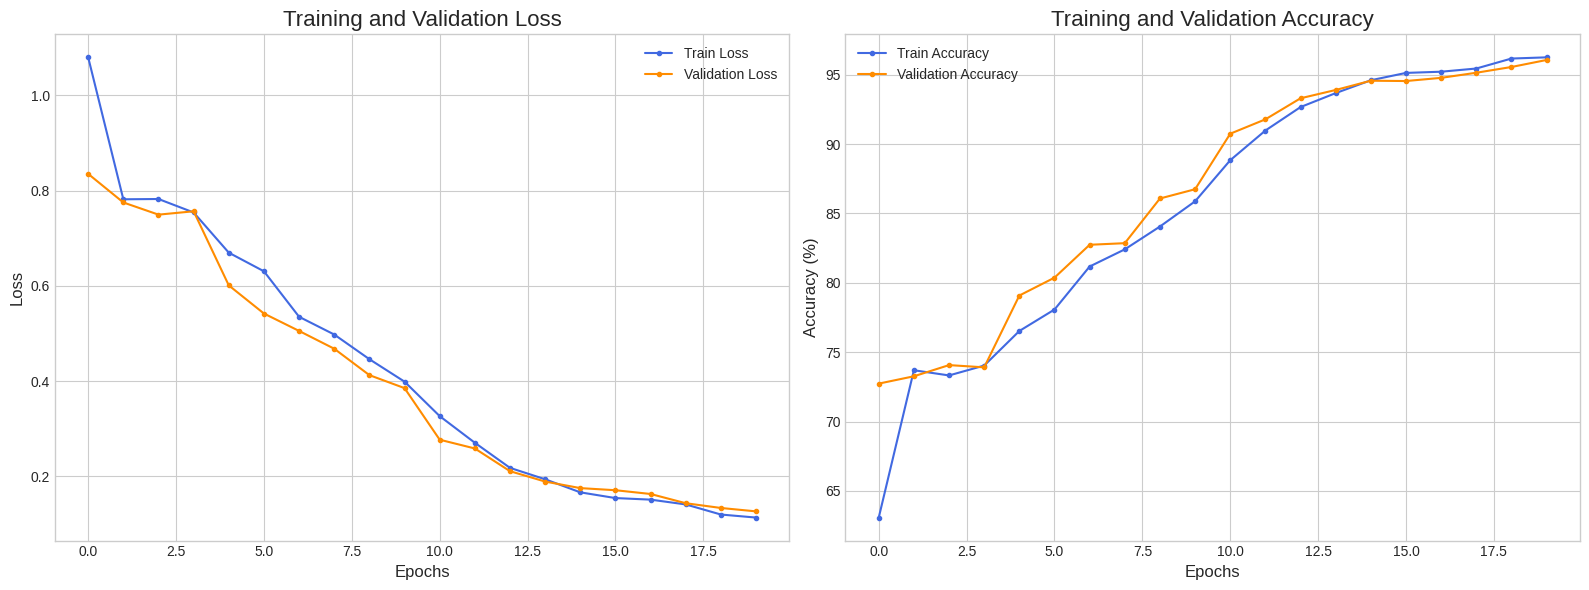

In [22]:
# --- 9. 훈련 과정 시각화 (CNN과 동일) ---
print("\n--- 9. 훈련 과정 시각화 ---")
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(history['train_loss'], label='Train Loss', color='royalblue', marker='o', markersize=3)
ax1.plot(history['val_loss'], label='Validation Loss', color='darkorange', marker='o', markersize=3)
ax1.set_title('Training and Validation Loss', fontsize=16)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend()
ax2.plot(history['train_acc'], label='Train Accuracy', color='royalblue', marker='o', markersize=3)
ax2.plot(history['val_acc'], label='Validation Accuracy', color='darkorange', marker='o', markersize=3)
ax2.set_title('Training and Validation Accuracy', fontsize=16)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.legend()
plt.tight_layout()
plt.show()



--- 10. 결과 분석 (Confusion Matrix on Test Data) ---


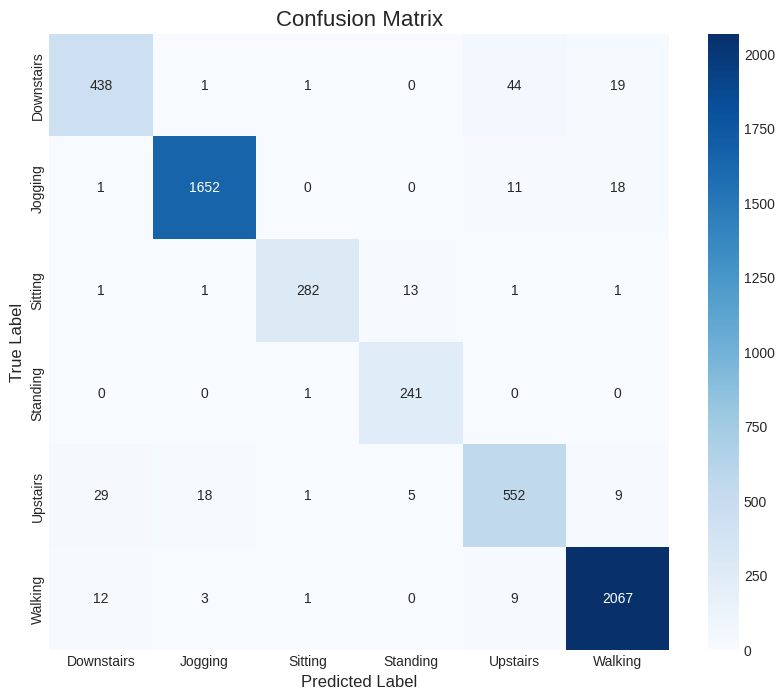

In [23]:
# --- 10. 결과 분석 (Confusion Matrix, CNN과 동일) ---
print("\n--- 10. 결과 분석 (Confusion Matrix on Test Data) ---")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()